In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import glob 
import cv2 
import keras 
from keras.metrics import MeanIoU 
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas 1.4.3
Scikit-Learn 1.1.1
GPU is available


In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.DenseNet201(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'DenseNet201.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [6]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - DenseNet201.h5")
    print("Model Saved!")

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [11]:
mpath = r'../AIDISS/Dataset/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    print(i)

ALL
ALL_RAW
BreaKHis_Total_dataset_RAW
Breast Cancer
Lung and Colon Cancer
Lung_and_Colon_Cancer_RAW
Lymphoma
Oral Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
74850304/74836368 [==============================] - 36s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             

625/625 [==============================] - 144s 187ms/step - loss: 6.2746 - accuracy: 0.8636 - val_loss: 1.5578 - val_accuracy: 0.9404

Epoch 00001: val_loss improved from inf to 1.55780, saving model to Lung and Colon CancerDenseNet201.h5
Epoch 2/20
625/625 [==============================] - 111s 178ms/step - loss: 2.7743 - accuracy: 0.9232 - val_loss: 3.8731 - val_accuracy: 0.9248

Epoch 00002: val_loss did not improve from 1.55780
Epoch 3/20
625/625 [==============================] - 111s 178ms/step - loss: 3.2367 - accuracy: 0.9335 - val_loss: 4.0719 - val_accuracy: 0.9312

Epoch 00003: val_loss did not improve from 1.55780
Epoch 4/20
625/625 [==============================] - 111s 178ms/step - loss: 2.8261 - accuracy: 0.9396 - val_loss: 2.8253 - val_accuracy: 0.9528

Epoch 00004: val_loss did not improve from 1.55780
Epoch 5/20
625/625 [==============================] - 112s 178ms/step - loss: 2.9887 - accuracy: 0.9488 - val_loss: 2.2553 - val_accuracy: 0.9544

Epoch 00005: val_lo

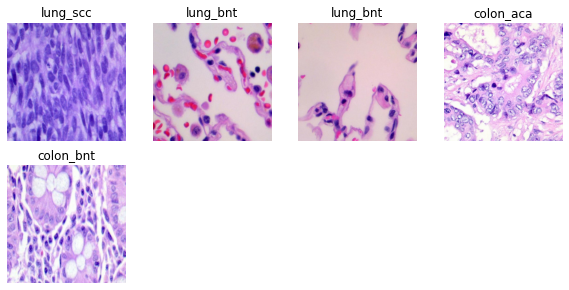

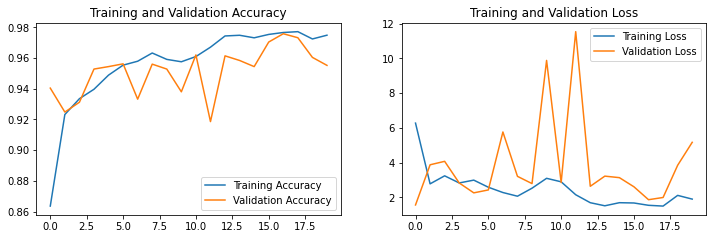

157/157 [==============================] - 22s 141ms/step - loss: 5.1678 - accuracy: 0.9552
Accuracy on the Test Set = 95.52 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

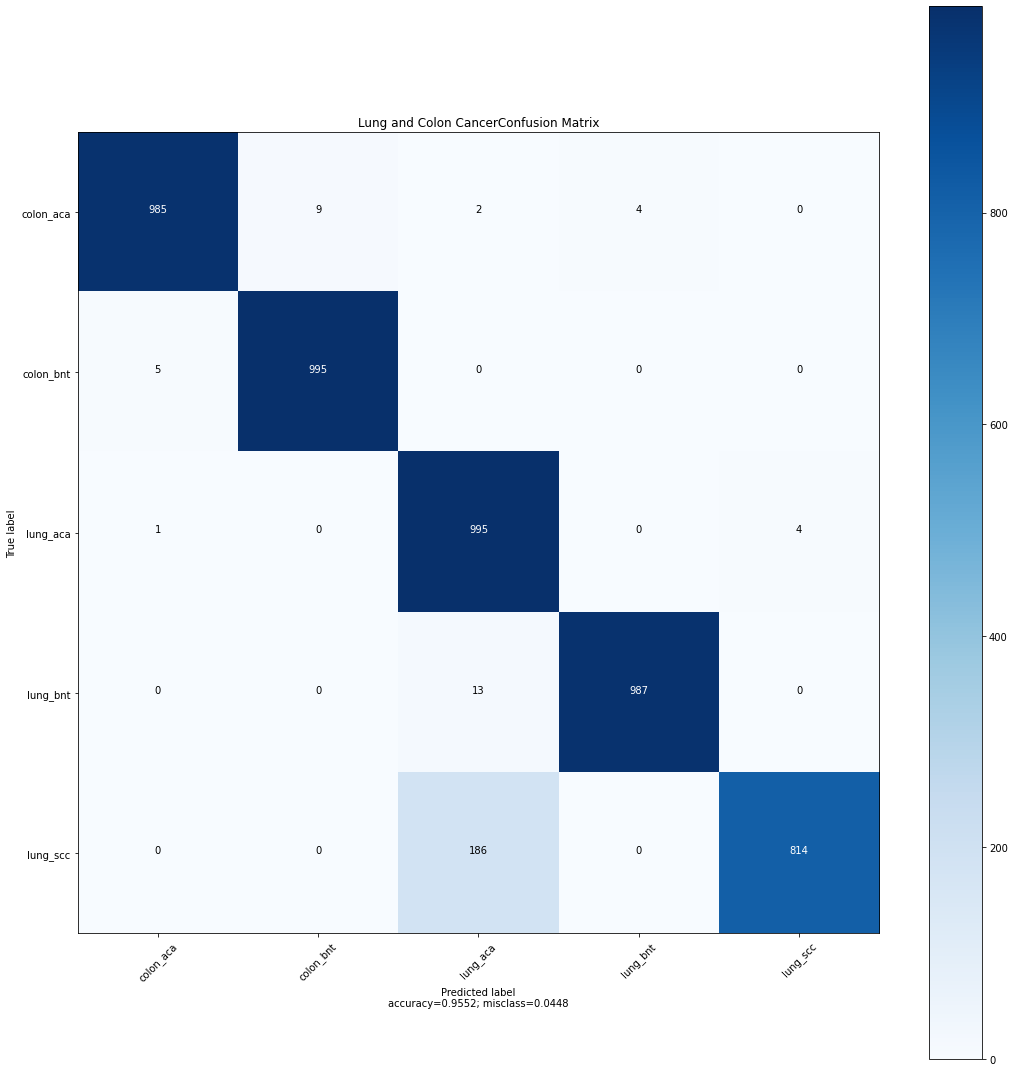

<Figure size 432x288 with 0 Axes>

In [12]:
className = 'Lung and Colon Cancer'
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 3256 files belonging to 4 classes.

For Training :  Found 2607 images belonging to 4 classes.

For Val :  Found 649 images belonging to 4 classes.

No of Classes :  4
Classes :  ['Benign', 'Early', 'Pre', 'Pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
_____________________________

82/82 [==============================] - 30s 275ms/step - loss: 10.5277 - accuracy: 0.8155 - val_loss: 4.0155 - val_accuracy: 0.8629

Epoch 00001: val_loss improved from inf to 4.01550, saving model to ALL_RAWDenseNet201.h5
Epoch 2/20
82/82 [==============================] - 14s 175ms/step - loss: 1.1010 - accuracy: 0.9513 - val_loss: 2.8088 - val_accuracy: 0.9153

Epoch 00002: val_loss improved from 4.01550 to 2.80884, saving model to ALL_RAWDenseNet201.h5
Epoch 3/20
82/82 [==============================] - 15s 184ms/step - loss: 0.2470 - accuracy: 0.9827 - val_loss: 3.9290 - val_accuracy: 0.8952

Epoch 00003: val_loss did not improve from 2.80884
Epoch 4/20
82/82 [==============================] - 15s 181ms/step - loss: 0.2810 - accuracy: 0.9797 - val_loss: 8.5832 - val_accuracy: 0.8459

Epoch 00004: val_loss did not improve from 2.80884
Epoch 5/20
82/82 [==============================] - 15s 178ms/step - loss: 0.2198 - accuracy: 0.9854 - val_loss: 4.3885 - val_accuracy: 0.8921

Epoc

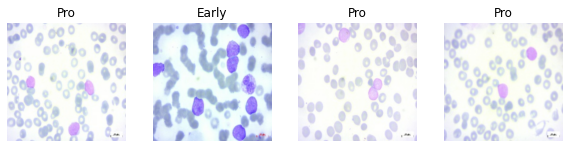

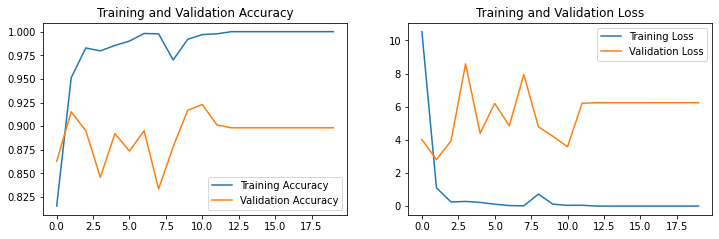

21/21 [==============================] - 3s 137ms/step - loss: 6.2415 - accuracy: 0.8983
Accuracy on the Test Set = 89.83 %
Model Saved!
True :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

<Figure size 432x288 with 0 Axes>

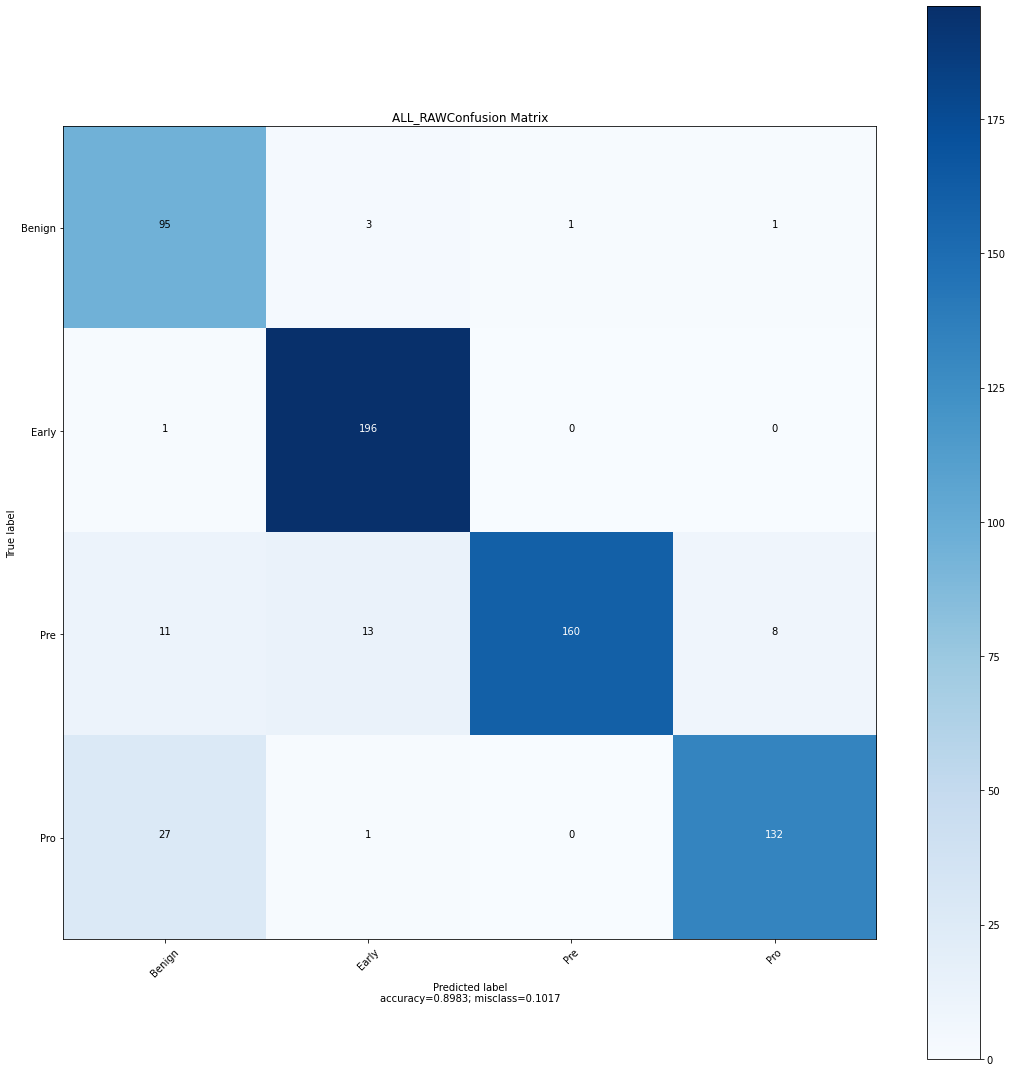

<Figure size 432x288 with 0 Axes>

In [13]:
className = 'ALL_RAW'
cpath = os.path.join(mpath, 'ALL_RAW')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________

500/500 [==============================] - 103s 189ms/step - loss: 3.1725 - accuracy: 0.9251 - val_loss: 1.0889 - val_accuracy: 0.9323

Epoch 00001: val_loss improved from inf to 1.08890, saving model to ALL DenseNet201.h5
Epoch 2/20
500/500 [==============================] - 87s 175ms/step - loss: 0.7803 - accuracy: 0.9707 - val_loss: 1.3548 - val_accuracy: 0.9530

Epoch 00002: val_loss did not improve from 1.08890
Epoch 3/20
500/500 [==============================] - 91s 181ms/step - loss: 0.3062 - accuracy: 0.9866 - val_loss: 1.2177 - val_accuracy: 0.9572

Epoch 00003: val_loss did not improve from 1.08890
Epoch 4/20
500/500 [==============================] - 88s 177ms/step - loss: 0.3619 - accuracy: 0.9864 - val_loss: 0.3443 - val_accuracy: 0.9900

Epoch 00004: val_loss improved from 1.08890 to 0.34427, saving model to ALL DenseNet201.h5
Epoch 5/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2394 - accuracy: 0.9920 - val_loss: 0.2768 - val_accuracy: 0.9915



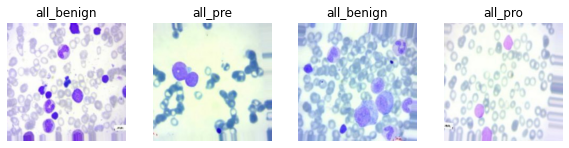

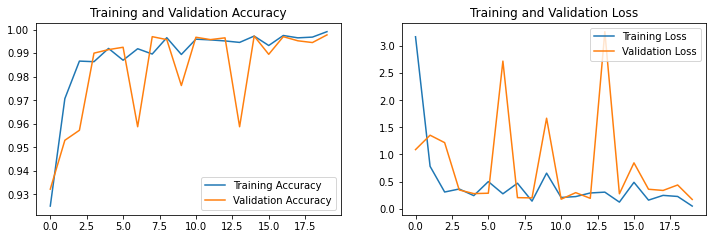

125/125 [==============================] - 17s 139ms/step - loss: 0.1689 - accuracy: 0.9977
Accuracy on the Test Set = 99.77 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

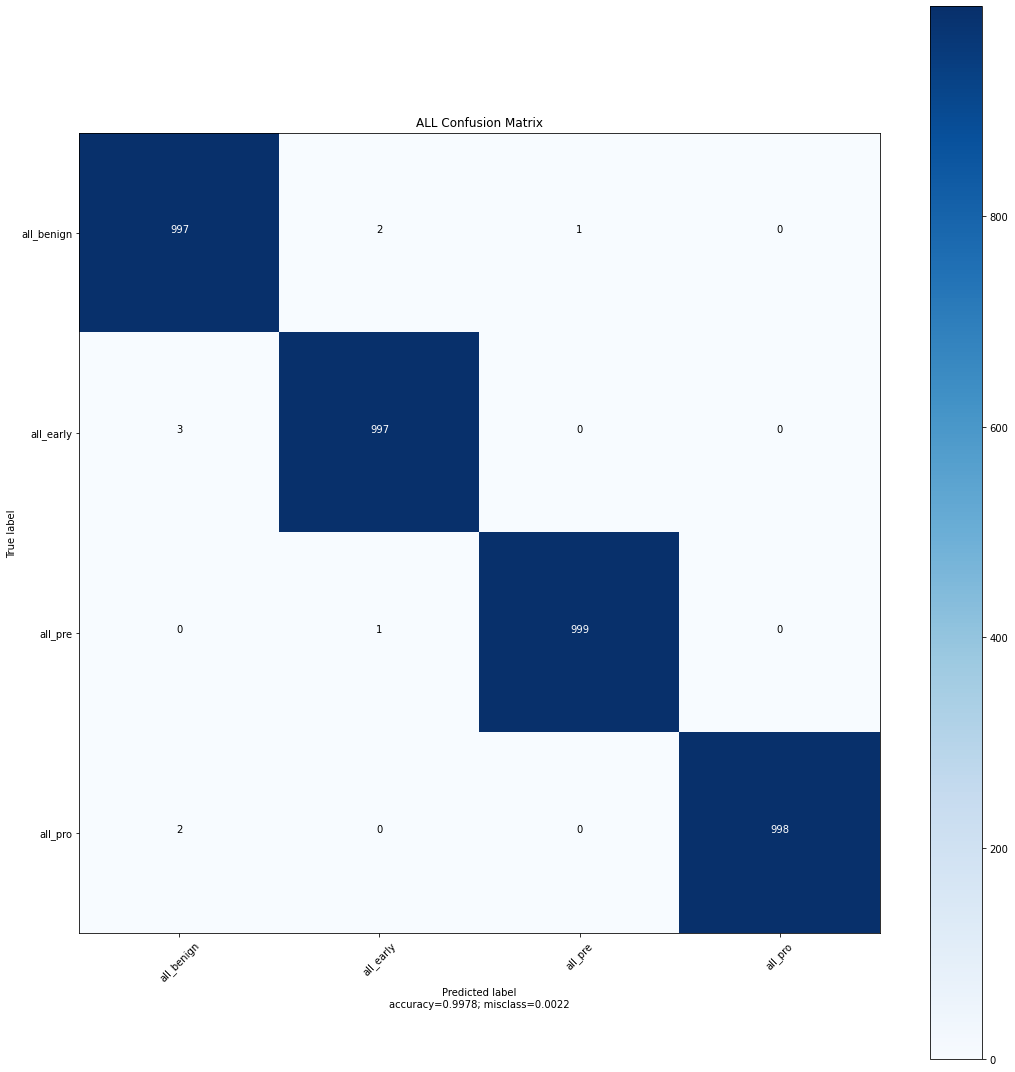

<Figure size 432x288 with 0 Axes>

In [14]:
className = 'ALL '
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=128)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 7783 files belonging to 2 classes.

For Training :  Found 6228 images belonging to 2 classes.

For Val :  Found 1555 images belonging to 2 classes.

No of Classes :  2
Classes :  ['benign', 'malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
______________________________________

Epoch 1/20
195/195 [==============================] - 89s 420ms/step - loss: 4.2330 - accuracy: 0.8357 - val_loss: 8.4817 - val_accuracy: 0.6965

Epoch 00001: val_loss improved from inf to 8.48174, saving model to BreaKHis_Total_dataset_RAWDenseNet201.h5
Epoch 2/20
195/195 [==============================] - 60s 306ms/step - loss: 2.0889 - accuracy: 0.8788 - val_loss: 5.9095 - val_accuracy: 0.7466

Epoch 00002: val_loss improved from 8.48174 to 5.90946, saving model to BreaKHis_Total_dataset_RAWDenseNet201.h5
Epoch 3/20
195/195 [==============================] - 60s 307ms/step - loss: 1.9689 - accuracy: 0.9027 - val_loss: 8.3256 - val_accuracy: 0.6514

Epoch 00003: val_loss did not improve from 5.90946
Epoch 4/20
195/195 [==============================] - 60s 305ms/step - loss: 1.7159 - accuracy: 0.9192 - val_loss: 7.2921 - val_accuracy: 0.7113

Epoch 00004: val_loss did not improve from 5.90946
Epoch 5/20
195/195 [==============================] - 59s 303ms/step - loss: 1.7394 - accura

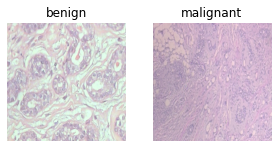

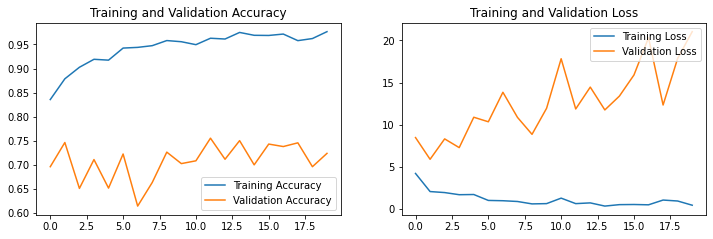

49/49 [==============================] - 12s 247ms/step - loss: 21.0224 - accuracy: 0.7241
Accuracy on the Test Set = 72.41 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 1 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

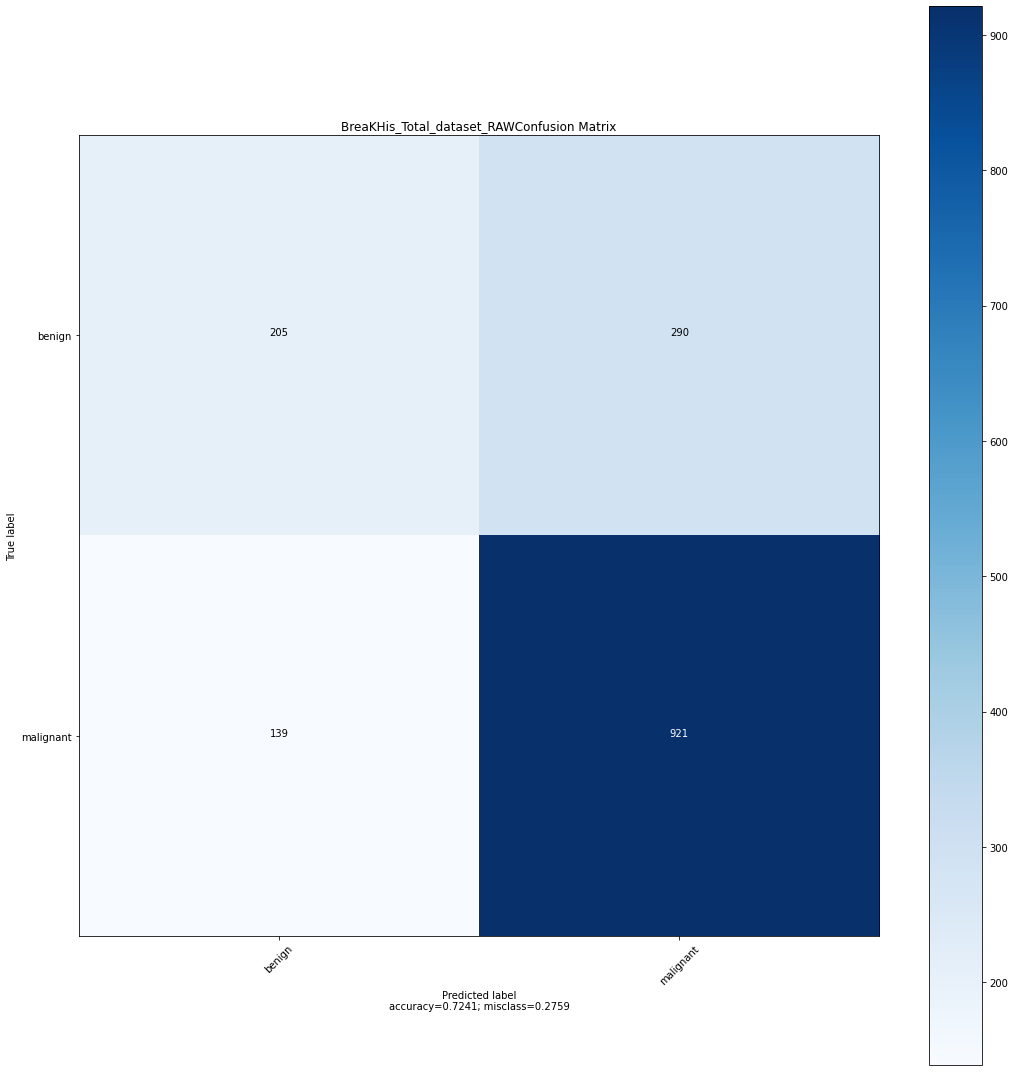

<Figure size 432x288 with 0 Axes>

In [15]:
className = 'BreaKHis_Total_dataset_RAW'
cpath = os.path.join(mpath, 'BreaKHis_Total_dataset_RAW')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_8[0][0]           
_______________________

Epoch 1/20
250/250 [==============================] - 67s 238ms/step - loss: 1.6974 - accuracy: 0.9279 - val_loss: 0.5157 - val_accuracy: 0.9665

Epoch 00001: val_loss improved from inf to 0.51573, saving model to Breast Cancer DenseNet201.h5
Epoch 2/20
250/250 [==============================] - 45s 179ms/step - loss: 0.9934 - accuracy: 0.9614 - val_loss: 0.8886 - val_accuracy: 0.9650

Epoch 00002: val_loss did not improve from 0.51573
Epoch 3/20
250/250 [==============================] - 47s 189ms/step - loss: 0.6017 - accuracy: 0.9746 - val_loss: 1.1523 - val_accuracy: 0.9645

Epoch 00003: val_loss did not improve from 0.51573
Epoch 4/20
250/250 [==============================] - 45s 180ms/step - loss: 0.5248 - accuracy: 0.9803 - val_loss: 1.1946 - val_accuracy: 0.9605

Epoch 00004: val_loss did not improve from 0.51573
Epoch 5/20
250/250 [==============================] - 45s 181ms/step - loss: 0.4657 - accuracy: 0.9824 - val_loss: 0.9688 - val_accuracy: 0.9695

Epoch 00005: val_los

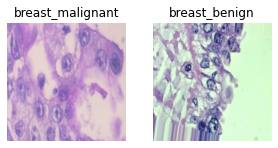

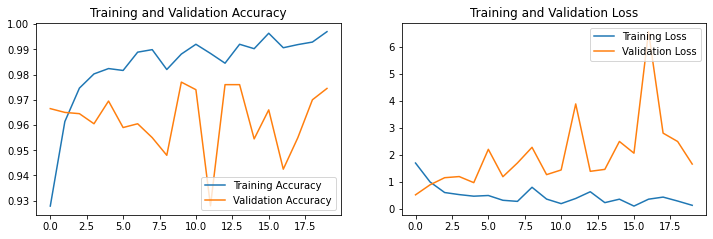

63/63 [==============================] - 9s 148ms/step - loss: 1.6591 - accuracy: 0.9745
Accuracy on the Test Set = 97.45 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

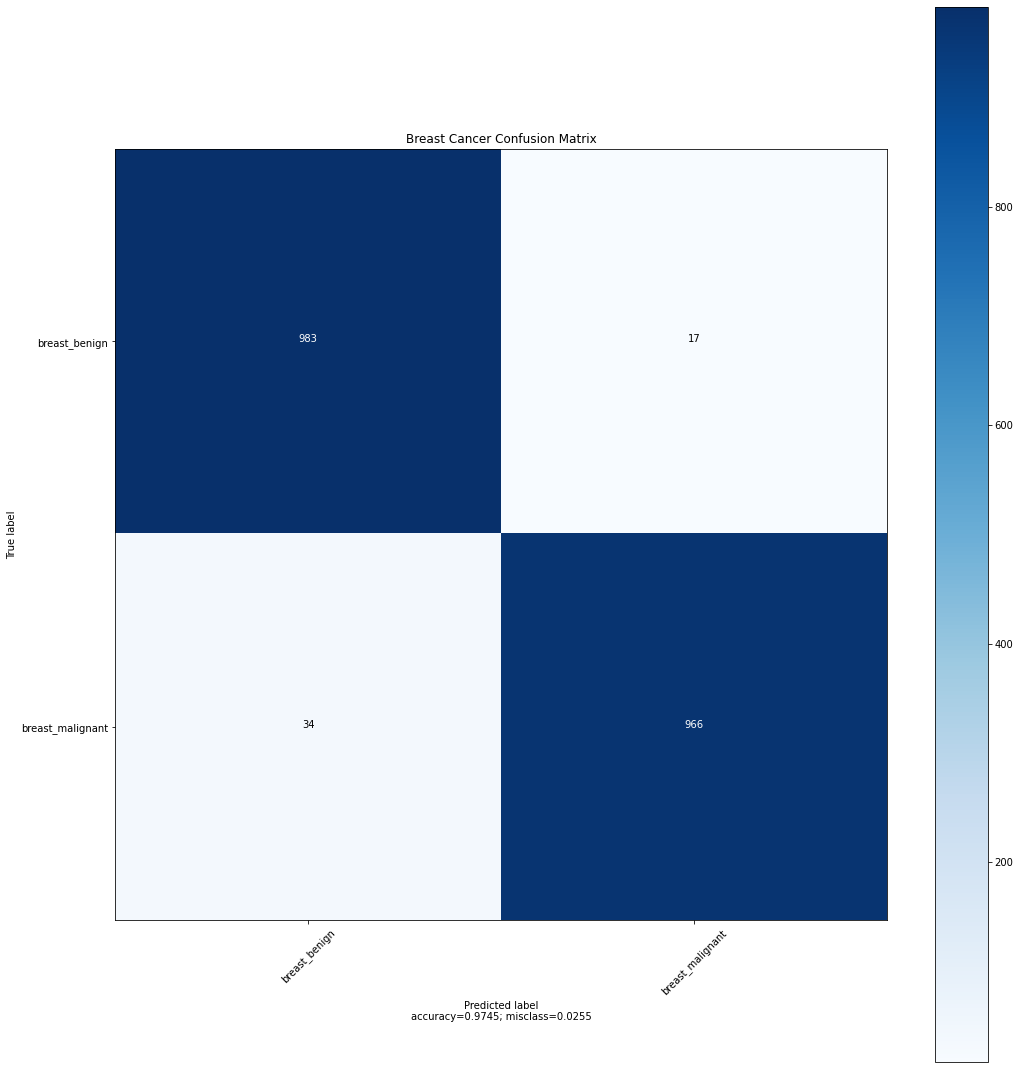

OSError: [Errno 22] Invalid argument: 'Breast Cancer Confusion Matrix.png'

<Figure size 432x288 with 0 Axes>

In [16]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)